# **Homework 13: Multi-Agent Reinforcement Learning**

#### **Course:** Deep Reinforcement Learning

---
## Problem 1: Nash Equilibrium (Theory)

A Nash Equilibrium (NE) represents a state where no player can improve their outcome by unilaterally changing their strategy. For our games, we'll focus on finding the mixed-strategy NE, where players choose their actions probabilistically.

### 1.1 Standard Rock-Scissors-Paper

Given the standard RSP payoff matrix:

| Player 1 | Rock | Scissors | Paper |
| :--- | :--: | :---: | :---: |
| **Rock** | 0, 0 | 1, -1 | -1, 1 |
| **Scissors**| -1, 1 | 0, 0 | 1, -1 |
| **Paper** | 1, -1 | -1, 1 | 0, 0 |


**Your Task:** Analytically derive the mixed-strategy Nash Equilibrium for this game. Show the steps for setting up the indifference equations for Player 1 and solving for Player 2's equilibrium strategy probabilities $(q_R, q_S, q_P)$. (find the Mixed Nash equilibrium of the game)

### 1.2 Modified Rock-Scissors-Paper

Now, consider the modified RSP game where the stakes are higher:

| Player 1 | Rock | Scissors | Paper |
| :--- | :--: | :---: | :---: |
| **Rock** | 0, 0 | 1, -1 | -2, 2 |
| **Scissors**| -1, 1 | 0, 0 | 3, -3 |
| **Paper** | 2, -2 | -3, 3 | 0, 0 |


**Your Task:** Like pervious one Derive the mixed-strategy Nash Equilibrium for this modified game.

---
## Problem 2: Learning by Observation - Fictitious Play (Implementation)

Fictitious Play is an intuitive learning algorithm where each agent models its opponent as playing a stationary strategy defined by the historical frequency of their past actions. The agent then plays a **best response** to this belief.

### 2.1 Implementation

**Your Task:** Implement the `simulate_fictitious_play` function below. It should take the payoff matrices for both players and the number of iterations as input. At each step, each player should choose the action that maximizes their expected payoff given the history of the opponent's plays.

**Algorithm:** At each time step $t > 0$, Player $i$ forms a belief that their opponent ($-i$) will play each action $a'$ with a probability equal to its historical frequency. The agent then chooses an action $a_i^*$ that is a best response to this belief.

Let $C_{t-1}(a_{-i})$ be the count of times opponent $-i$ has played action $a_{-i}$ up to step $t-1$. Player $i$'s best response is:
$$a_{i,t}^* = \arg\max_{a_i \in A_i} \sum_{a_{-i} \in A_{-i}} u_i(a_i, a_{-i}) \cdot \frac{C_{t-1}(a_{-i})}{t-1}$$

**Note on Tie-Breaking:** If multiple actions yield the same maximal expected payoff, your agent should choose one of these best responses uniformly at random.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def simulate_fictitious_play(A, B, iterations):
    """
    Simulates Fictitious Play for two players in a normal-form game.

    Args:
        A (np.ndarray): Payoff matrix for Player 1 (m x n).
        B (np.ndarray): Payoff matrix for Player 2 (m x n).
        iterations (int): The number of rounds to play.

    Returns:
        tuple:
            - p1_freq_history (np.ndarray): History of Player 1's action frequencies.
            - p2_freq_history (np.ndarray): History of Player 2's action frequencies.
    """
    m, n = A.shape  # m = # of actions for P1, n = # of actions for P2

    # Action counts
    p1_counts = np.zeros(m)
    p2_counts = np.zeros(n)

    # History storage
    p1_freq_history = np.zeros((iterations, m))
    p2_freq_history = np.zeros((iterations, n))

    # First move: pick uniformly at random
    p1_action = np.random.choice(m)
    p2_action = np.random.choice(n)
    p1_counts[p1_action] += 1
    p2_counts[p2_action] += 1

    p1_freq_history[0] = p1_counts / 1
    p2_freq_history[0] = p2_counts / 1

    # Simulation loop
    for t in range(1, iterations):
        # Compute opponent's empirical frequencies
        p2_freq = p2_counts / t
        p1_freq = p1_counts / t

        # Expected payoffs
        exp_payoffs_p1 = A @ p2_freq
        exp_payoffs_p2 = (p1_freq @ B).T

        # Best responses with random tie-breaking
        best_actions_p1 = np.flatnonzero(exp_payoffs_p1 == exp_payoffs_p1.max())
        best_actions_p2 = np.flatnonzero(exp_payoffs_p2 == exp_payoffs_p2.max())

        p1_action = np.random.choice(best_actions_p1)
        p2_action = np.random.choice(best_actions_p2)

        # Update counts
        p1_counts[p1_action] += 1
        p2_counts[p2_action] += 1

        # Store frequencies
        p1_freq_history[t] = p1_counts / (t + 1)
        p2_freq_history[t] = p2_counts / (t + 1)

    return p1_freq_history, p2_freq_history

    # --- Payoff Matrices ---
A_std = np.array([[0, 1, -1], [-1, 0, 1], [1, -1, 0]])
A_mod = np.array([[0, 1, -2], [-1, 0, 3], [2, -3, 0]])


### 2.2 Analysis

**Your Task:**
1.  Run your simulation for **1,000,000 iterations** on both the **standard** and **modified** RSP games.
2.  Generate two plots, one for each game. Each plot should show the evolution of Players action frequencies over time and include horizontal lines indicating the theoretical NE probabilities you calculated in Problem 1.
3.  **Analyze your results:** Do the action frequencies converge? If so, do they converge to the Nash Equilibrium? Explain the observed behavior.

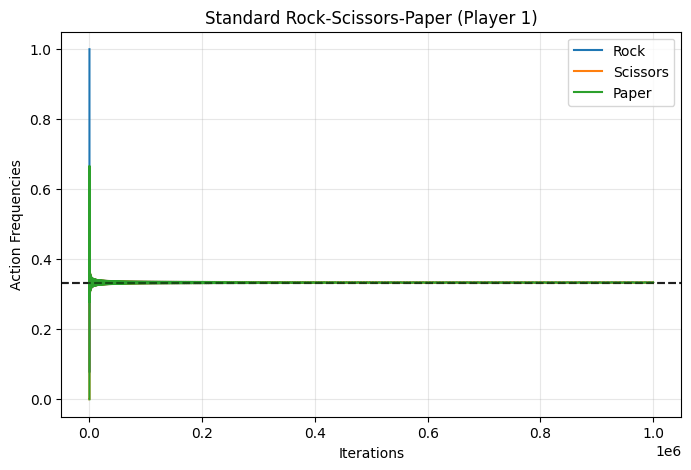

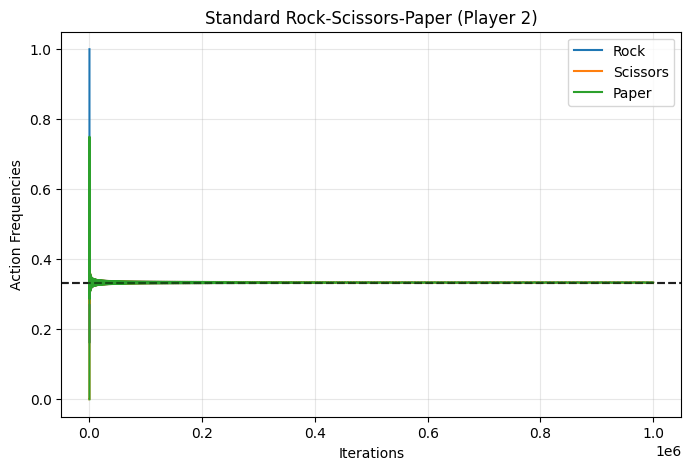

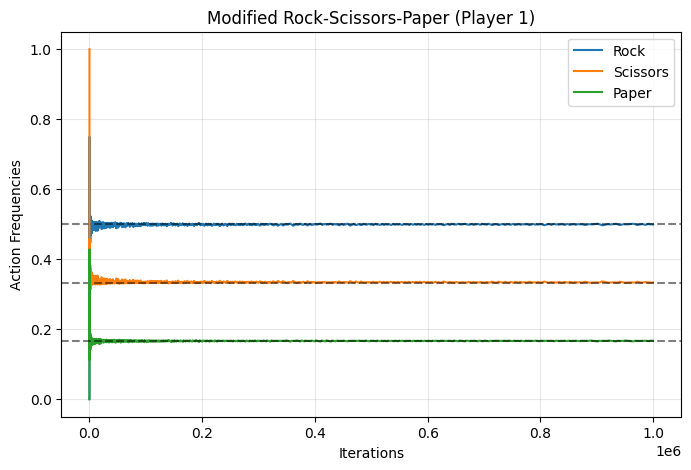

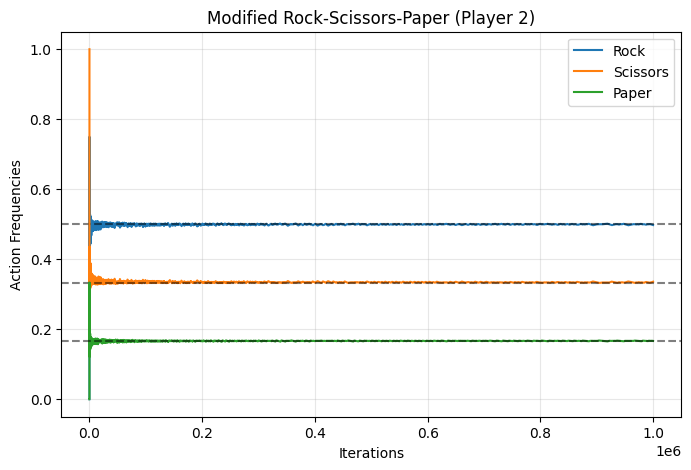

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# --- Payoff Matrices ---
B_std = -A_std  # zero-sum
B_mod = -A_mod  # zero-sum


def plot_results(freq_history, title, ne_probs):
    plt.figure(figsize=(8, 5))
    for i, label in enumerate(["Rock", "Scissors", "Paper"]):
        plt.plot(freq_history[:, i], label=label)
        plt.axhline(ne_probs[i], linestyle="--", color="k", alpha=0.5)

    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Action Frequencies")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


if __name__ == "__main__":
    iterations = 1_000_000

    # Standard RSP NE: uniform distribution
    ne_std = np.array([1/3, 1/3, 1/3])
    p1_std, p2_std = simulate_fictitious_play(A_std, B_std, iterations)
    plot_results(p1_std, "Standard Rock-Scissors-Paper (Player 1)", ne_std)
    plot_results(p2_std, "Standard Rock-Scissors-Paper (Player 2)", ne_std)

    # Modified RSP NE: solve by hand or linear system
    ne_mod =  np.array([1/2, 1/3, 1/6])
    p1_mod, p2_mod = simulate_fictitious_play(A_mod, B_mod, iterations)
    plot_results(p1_mod, "Modified Rock-Scissors-Paper (Player 1)", ne_mod)
    plot_results(p2_mod, "Modified Rock-Scissors-Paper (Player 2)", ne_mod)


---
## Problem 3: Fictitious Play with Exploration (Implementation)

Our Fictitious Play agent is purely exploitative. In Reinforcement Learning, we know the importance of the **exploration-exploitation tradeoff**. Let's create an $\epsilon$-greedy version of Fictitious Play.

### 3.1 Implementation

**Your Task:** Create a new function, `simulate_epsilon_greedy_fp`. This function should be similar to your Fictitious Play implementation but include an `epsilon` parameter. At each step, with probability `epsilon`, the agent should choose a random action (explore). With probability `1-epsilon`, it should play the best response (exploit).

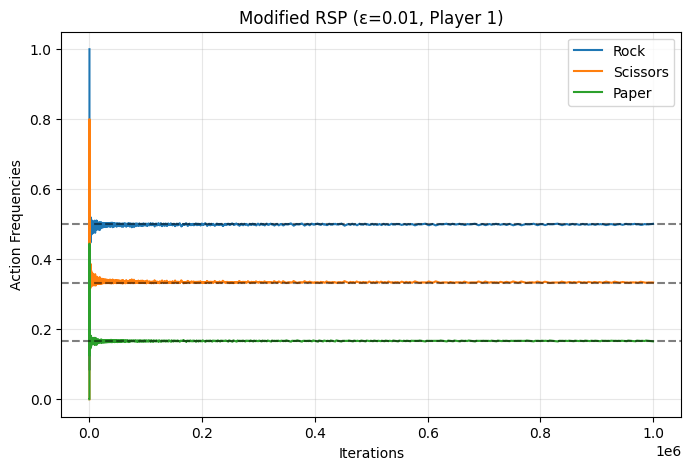

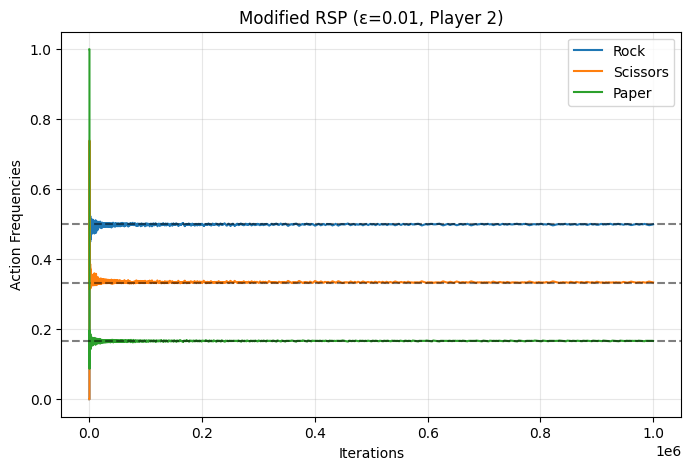

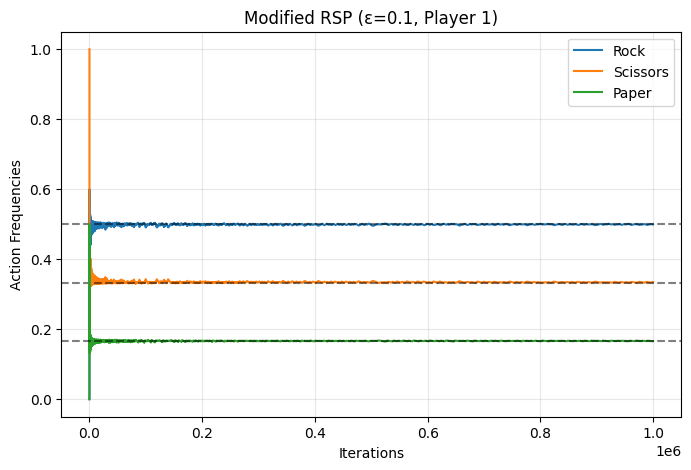

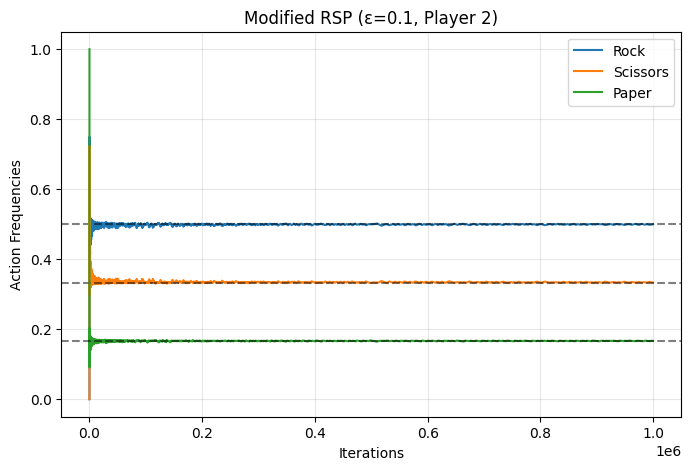

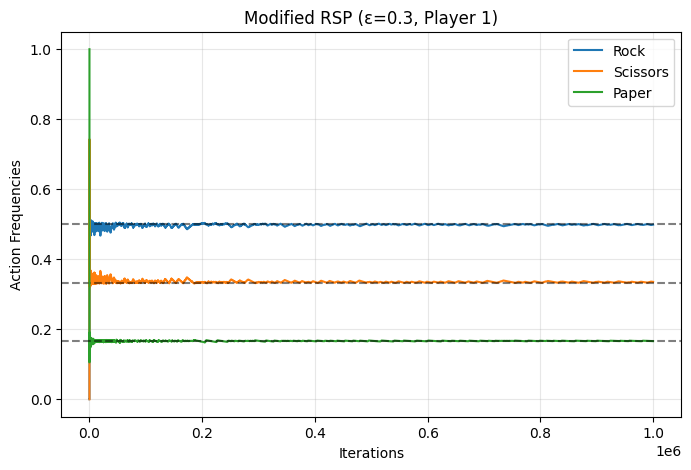

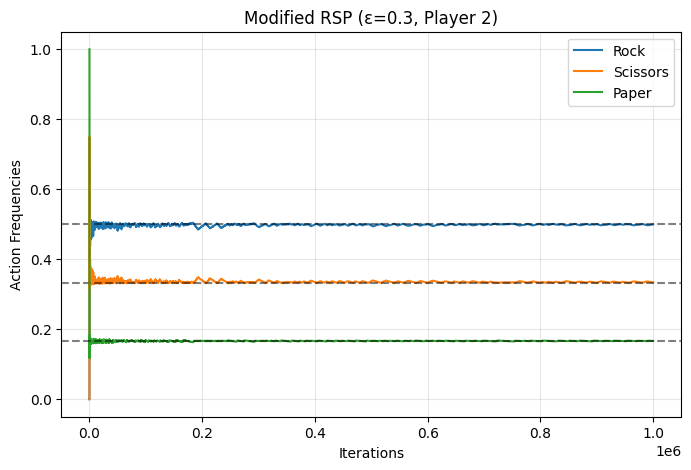

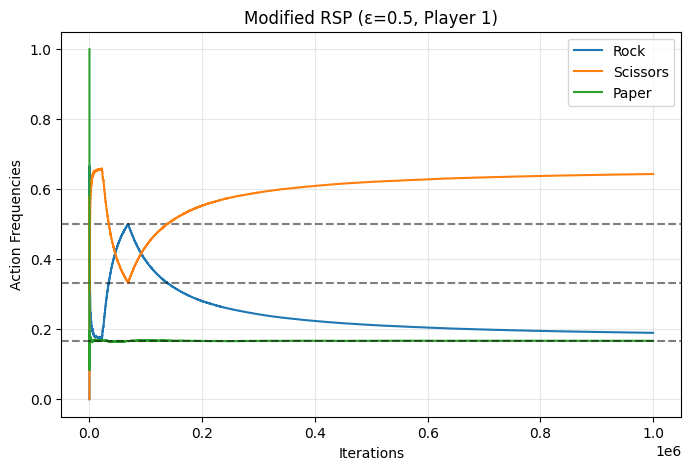

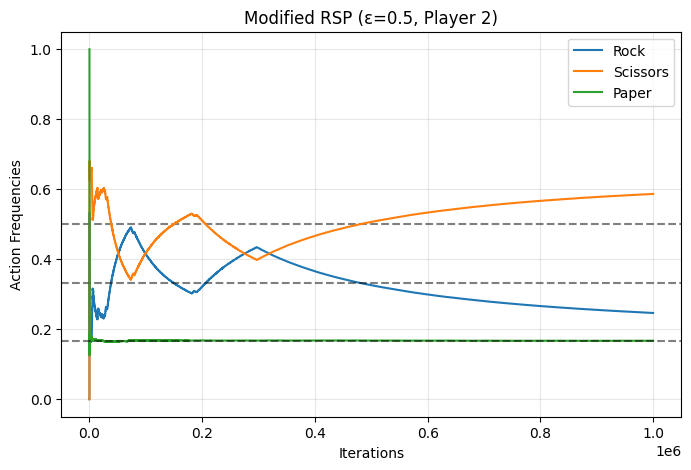

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_epsilon_greedy_fp(A, B, iterations, epsilon):
    """
    Simulates epsilon-greedy Fictitious Play for two players.

    Args:
        A (np.ndarray): Payoff matrix for Player 1 (m x n).
        B (np.ndarray): Payoff matrix for Player 2 (m x n).
        iterations (int): Number of iterations to simulate.
        epsilon (float): Exploration probability.

    Returns:
        tuple:
            - p1_freq_history (np.ndarray): History of Player 1's action frequencies.
            - p2_freq_history (np.ndarray): History of Player 2's action frequencies.
    """
    m, n = A.shape

    # Action counts
    p1_counts = np.zeros(m)
    p2_counts = np.zeros(n)

    # History storage
    p1_freq_history = np.zeros((iterations, m))
    p2_freq_history = np.zeros((iterations, n))

    # First move: random
    p1_action = np.random.choice(m)
    p2_action = np.random.choice(n)
    p1_counts[p1_action] += 1
    p2_counts[p2_action] += 1

    p1_freq_history[0] = p1_counts / 1
    p2_freq_history[0] = p2_counts / 1

    for t in range(1, iterations):
        # Compute opponent empirical frequencies
        p2_freq = p2_counts / t
        p1_freq = p1_counts / t

        # Expected payoffs
        exp_payoffs_p1 = A @ p2_freq
        exp_payoffs_p2 = (p1_freq @ B).T

        # Best response sets
        best_actions_p1 = np.flatnonzero(exp_payoffs_p1 == exp_payoffs_p1.max())
        best_actions_p2 = np.flatnonzero(exp_payoffs_p2 == exp_payoffs_p2.max())

        # --- ε-greedy choice ---
        if np.random.rand() < epsilon:  # explore
            p1_action = np.random.choice(m)
        else:  # exploit
            p1_action = np.random.choice(best_actions_p1)

        if np.random.rand() < epsilon:
            p2_action = np.random.choice(n)
        else:
            p2_action = np.random.choice(best_actions_p2)

        # Update counts
        p1_counts[p1_action] += 1
        p2_counts[p2_action] += 1

        # Record frequencies
        p1_freq_history[t] = p1_counts / (t + 1)
        p2_freq_history[t] = p2_counts / (t + 1)

    return p1_freq_history, p2_freq_history


if __name__ == "__main__":
    iterations = 1_000_000
    epsilons = [0.01, 0.1, 0.3, 0.5]

    for eps in epsilons:
        p1_hist, p2_hist = simulate_epsilon_greedy_fp(A_mod, B_mod, iterations, eps)
        plot_results(p1_hist, f"Modified RSP (ε={eps}, Player 1)", ne_mod)
        plot_results(p2_hist, f"Modified RSP (ε={eps}, Player 2)", ne_mod)



### 3.2 Analysis

**Your Task:**
1.  Run the `simulate_epsilon_greedy_fp` function on the **modified** RSP game for **1,000,000 iterations** with three different `epsilon` values: `0.01`, `0.1`, and `0.3`.
2.  Plot the results for each simulation.
3.  **Analyze your results:** How does `epsilon` affect the learning dynamics? Does the agent's strategy still converge to the NE? If not, to what does it converge? Discuss the impact of exploration in this multi-agent context.

---
## Problem 4: Learning from "What If" - Regret Matching (Implementation & Theory)

Regret Matching is a powerful no-regret learning algorithm. Instead of playing a best response to history, an agent's probability of choosing an action is proportional to the positive **regret** for not having chosen that action in the past. The key property of regret matching is that the **average strategy** over time converges to a Nash Equilibrium.

### 4.1 Implementation

**Your Task:** Implement the `simulate_regret_matching` function below.

**Algorithm:** Regret Matching works in two steps. First, update the cumulative regrets. Second, determine the next round's strategy.

1.  **Regret Calculation:** After playing action $a_i$ against opponent's action $a_{-i}$, the cumulative regret $R_t(s)$ for *not* having played action $s \in A_i$ is updated as follows:
    $$R_t(s) = R_{t-1}(s) + u_i(s, a_{-i}) - u_i(a_i, a_{-i})$$

2.  **Strategy Calculation:** The probability of playing action $s$ in the next round is proportional to its positive cumulative regret, $R_t^+(s) = \max(0, R_t(s))$.
    $$p_{t+1}(s) = \frac{R_t^+(s)}{\sum_{s' \in A_i} R_t^+(s')}$$
    If the sum of positive regrets is zero, play uniformly at random.

In [7]:
def simulate_regret_matching(A, B, iterations):
    """
    Simulates Regret Matching for two players.

    Returns:
        tuple: A tuple containing:
            - p1_avg_strat_hist (np.ndarray): History of Player 1's average strategy.
            - p1_inst_strat_hist (np.ndarray): History of Player 1's instantaneous strategy.
    """
    num_actions = A.shape[0]

    ### YOUR CODE HERE ###
    # Initialize regrets, strategy sums, and history lists
    # Loop for iterations
    # Calculate the current strategy based on positive regrets
    #   (If sum of positive regrets is 0, play uniformly random)
    # Store the instantaneous strategy and add to the strategy sum
    # Choose actions based on the current strategies
    # Update regrets for ALL actions based on the outcome
    # Periodically record the average and instantaneous strategies

    num_actions = A.shape[0]  # assume square matrix for simplicity

    # --- Storage ---
    regrets_p1 = np.zeros(num_actions)
    strategy_sum_p1 = np.zeros(num_actions)

    p1_inst_strat_hist = np.zeros((iterations, num_actions))
    p1_avg_strat_hist = np.zeros((iterations, num_actions))

    # initialize opponent regrets too (symmetric setup)
    regrets_p2 = np.zeros(num_actions)
    strategy_sum_p2 = np.zeros(num_actions)

    # --- Simulation loop ---
    for t in range(iterations):
        # --- Compute current strategies from regrets ---
        pos_regrets_p1 = np.maximum(regrets_p1, 0)
        pos_regrets_p2 = np.maximum(regrets_p2, 0)

        if pos_regrets_p1.sum() > 0:
            strat_p1 = pos_regrets_p1 / pos_regrets_p1.sum()
        else:
            strat_p1 = np.ones(num_actions) / num_actions

        if pos_regrets_p2.sum() > 0:
            strat_p2 = pos_regrets_p2 / pos_regrets_p2.sum()
        else:
            strat_p2 = np.ones(num_actions) / num_actions

        # --- Store histories ---
        p1_inst_strat_hist[t] = strat_p1
        strategy_sum_p1 += strat_p1
        p1_avg_strat_hist[t] = strategy_sum_p1 / (t + 1)

        # --- Sample actions ---
        a1 = np.random.choice(num_actions, p=strat_p1)
        a2 = np.random.choice(num_actions, p=strat_p2)

        # --- Payoffs ---
        u1 = A[a1, a2]
        u2 = B[a1, a2]

        # --- Update regrets ---
        for s in range(num_actions):
            regrets_p1[s] += A[s, a2] - u1
            regrets_p2[s] += B[a1, s] - u2

    return p1_avg_strat_hist, p1_inst_strat_hist



### 4.2 Analysis

**Your Task:**
1.  Run your simulation for the **modified** RSP game for **1,000,000 iterations**.
2.  Generate a single figure with two subplots:
    * **Subplot 1:** Plot the **instantaneous strategy** of Player 1 over time.
    * **Subplot 2:** Plot the **average strategy** of Player 1 over time. Include horizontal lines for the NE.
3.  **Analyze your results:** Compare the two plots. Which one converges to the Nash Equilibrium? \
                              (Bonus): Explain why this is the expected theoretical outcome for Regret Matching algorithms.

/tmp/ipython-input-1097008260.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


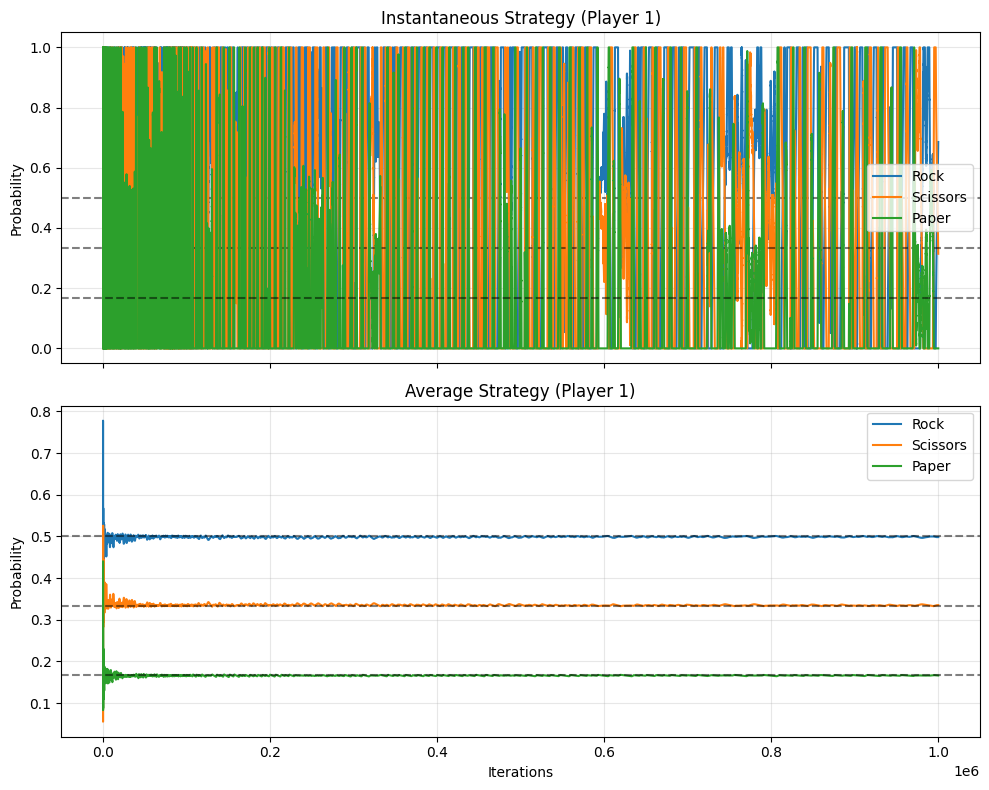

In [8]:
def plot_regret_matching(avg_hist, inst_hist, ne_probs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    labels = ["Rock", "Scissors", "Paper"]

    # --- Instantaneous strategy ---
    for i, label in enumerate(labels):
        axs[0].plot(inst_hist[:, i], label=label)
        axs[0].axhline(ne_probs[i], linestyle="--", color="k", alpha=0.5)
    axs[0].set_title("Instantaneous Strategy (Player 1)")
    axs[0].set_ylabel("Probability")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # --- Average strategy ---
    for i, label in enumerate(labels):
        axs[1].plot(avg_hist[:, i], label=label)
        axs[1].axhline(ne_probs[i], linestyle="--", color="k", alpha=0.5)
    axs[1].set_title("Average Strategy (Player 1)")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Probability")
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    iterations = 1_000_000
    p1_avg, p1_inst = simulate_regret_matching(A_mod, B_mod, iterations)
    plot_regret_matching(p1_avg, p1_inst, ne_mod)